In [1]:
import numpy as np
import bls_cpu as gbls
import transitPy5 as tpy5
import os
# os.environ["OMP_NUM_THREADS"] = "48"

In [2]:
import importlib

In [3]:
importlib.reload(gbls)

<module 'bls_cpu' from '/home/rowe/python/bls_cuda/bls_cpu.py'>

In [4]:
gbls_inputs = gbls.gbls_inputs_class() # Initialize needed inputs

tic = 29991541
gbls_inputs.lcdir    = "/opt/data2/TESS/ffisearch/cvzsearch_yr1/cvz1pt003/tlc"+str(tic)+"/"
# gbls_inputs.filename = "tlc"+str(tic)+"_5.dc.dat"
gbls_inputs.filename = "tlc"+str(tic)+".dat"

# Read in photometry to photclass
phot = tpy5.readphot(gbls_inputs.lcdir + gbls_inputs.filename)

# Remove any offset from time stamps
gbls_inputs.zerotime = 1325.0

# 0 == no plots ; 1 = make a plot ; 2 make a plot and save it ; 3 just save the plot
gbls_inputs.plots = 1  #default is 1 

# Set frequency range by setting freqs1 and freqs2
# gbls_inputs.freq1 = 1/100 # scan from 100 days to 2 days
# gbls_inputs.freq2 = 1/2

# Set stellar parameters for optimum duration search
# gbls_inputs.Mstar = 1.0  #default is M = 1, R = 1
# gbls_inputs.Rstar = 1.0

# Set multipro = 0 for single thread jobs.  Default is 1.  
# gbls_inputs.multipro = 1

In [5]:
## Data processing 

# # Simple sigma cut on the data
# fstd = np.std(phot.flux)
# fstd_flag  = (np.abs(phot.flux - np.median(phot.flux)) < tpy5_inputs.fstd_cut*fstd) # & badcut
# phot.time  = phot.time[fstd_flag]
# phot.flux  = phot.flux[fstd_flag]
# phot.ferr  = phot.ferr[fstd_flag]
# phot.itime = phot.itime[fstd_flag]
# phot.tflag = phot.tflag[fstd_flag]
# phot.icut  = phot.icut[fstd_flag]


# This class will eventually end up in tpy5.  Will move when input parameters is more complete.  
class tpy5_inputs_class:
    def __init__(self):
        self.photfile  = "filename.txt"
        self.photdir   = "/path/to/photometry/"
        self.roi       = 210.01 # Roman ID
        self.boxbin    = 5.0    # Detrending window
        self.gapsize   = 0.5    # Detection of gaps in the data -- we do not detrend over gaps
        self.nfitp     = 2      # Order of polynomial for detrending.  2 = quadratic
        self.dsigclip  = 3.0    # Sigma clipping for derivative routine
        self.nsampmax  = 6      # Sample size for derivative routine
        self.detrended = 0      # Track if detrended data is used/created
        self.dataclip  = 0      # Track if clipped data is used/created 
        self.fstd_cut  = 3      # Simple Sigma-clipping

tpy5_inputs = tpy5_inputs_class()

# Detrender
tpy5.run_polyfilter(phot, tpy5_inputs) # -- will add flux_f to phot class

# Outlier rejection
tpy5.run_cutoutliers(phot, tpy5_inputs)

# Simple sigma cut on the data
fstd = np.std(phot.flux)
fstd_flag  = (np.abs(phot.flux - np.median(phot.flux)) < tpy5_inputs.fstd_cut*fstd) # & badcut

In [6]:
# importlib.reload(gbls)

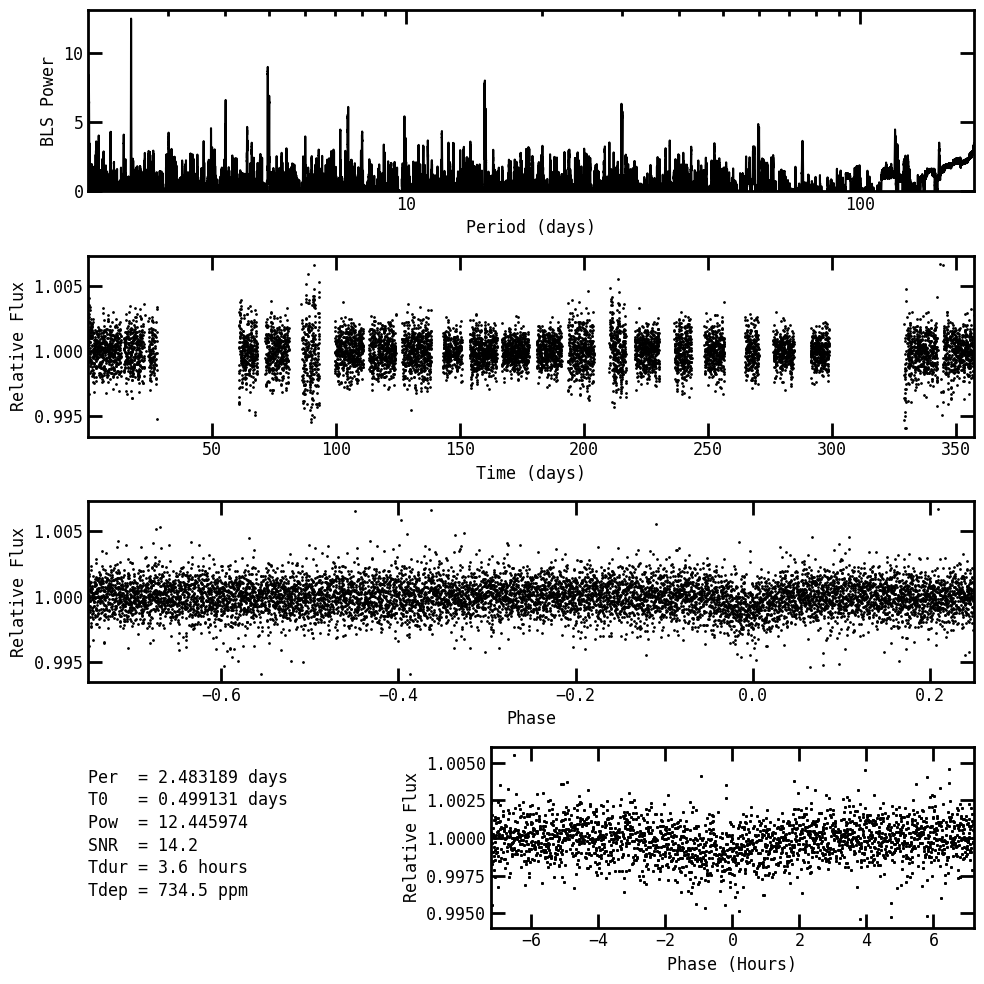

In [7]:
# If you used data processing, use phot.flux_f
# importlib.reload(gbls)
gbls_inputs.freq1 = 2/(np.max(phot.time) - np.min(phot.time))
gbls_inputs.freq2 = 0.5
gbls_ans = gbls.bls(gbls_inputs, phot.time[fstd_flag & (phot.icut == 0)], phot.flux_f[fstd_flag & (phot.icut == 0)])

## Python Transit modelling section

- needs preconditioning of data prior to modelling. (protect transits during detrending and clipping)
- move zerotime to routine to leave original phot.time intack
- use flux_f instead of flux for modelling -- leaves original photometry intack
- use icut and other flags to mark bad data 

In [8]:
import utils_python.transitmodel as transitm
import utils_python.keplerian as kep
import utils_python.transitfit as transitf
import utils_python.transitplot as transitp
from exotic_ld import StellarLimbDarkening

/home/rowe/python/xrp_env/lib64/python3.13/site-packages/exotic_ld/ld_grids.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [9]:
# Create an initial guess for all 18 parameters
sol = transitm.transit_model_class() # Single planet model has up-to 18-model parameters
sol.rho = kep.rhostar(gbls_ans.bper, gbls_ans.tdur)    # Mean stellar density (g/cm^3)
sol.nl1 = 0.0    # Only used for non-linear limb-darkening
sol.nl2 = 0.0    # Only used for non-linear limb-darkening
sol.dil = 0.0    # dilution
sol.vof = 0.0    # Velocity offset
sol.zpt = 0.0       # Photometric zero point
sol.t0  = [gbls_ans.epo]             # Center of transit time (days)
sol.per = [gbls_ans.bper]            # Orbital Period (days)
sol.bb  = [0.5]                      # Impact parameter
sol.rdr = [np.sqrt(gbls_ans.depth)]  # Rp/R*
sol.ecw = [0.0]  # sqrt(e)cos(w)
sol.esw = [0.0]  # sqrt(e)sin(w)
sol.krv = [0.0]  # RV amplitude (m/s)
sol.ted = [0.0]  # thermal eclipse depth (ppm)
sol.ell = [0.0]  # Ellipsodial variations (ppm)
sol.alb = [0.0]  # Albedo amplitude (ppm)
sol.npl = 1         # Number of planets

# Find Kipping limb-darkening coefficients
M_H = 0.2
Teff = 5400
logg = 4.45

ld_data_path = '/opt/data2/rowe/exotic_ld_data/'  #Remove 'opt' for exo/kona
ld_model = 'mps1'
sld = StellarLimbDarkening(M_H, Teff, logg, ld_model, ld_data_path)
ld, ld_sig = sld.compute_kipping_ld_coeffs(wavelength_range=[0.6*10000, 1.0*10000], mode="TESS", mu_min=0.1, return_sigmas=True)
sol.nl3 = ld[0]
sol.nl4 = ld[1]

In [10]:
phot.ferr = np.full(len(phot.flux_f), np.std(phot.flux_f))
phot.time -= gbls_inputs.zerotime

In [11]:
phot.flux = np.copy(phot.flux_f) # fitting is done on phot.flux, but BLS may use flux_f for searches.  

In [12]:
# Define the parameters to fit
params_to_fit = ["rho", "zpt", "t0", "per", "bb", "rdr"]

# Fit the data
sol_fit = transitf.fitTransitModel(sol, params_to_fit, phot)

In [13]:
# Plotting
transitp.printParams(sol_fit)

ρ* (g/cm³):                     0.1518035 ± 3.7729853
c1:                                   0.0 ± 0.0
c2:                                   0.0 ± 0.0
q1:                             0.3545084 ± 0.0000000
q2:                             0.3205229 ± 0.0000000
Dilution:                             0.0 ± 0.0
Velocity Offset:                      0.0 ± 0.0
Photometric zero point:         8.411e-05 ± 2.340e-05
t0 (days):                      0.4555991 ± 0.0118502
Period (days):                  2.4834630 ± 0.0001455
Impact parameter:               0.5995437 ± 9.6917501
Rp/R*:                          0.0282696 ± 0.0529056
sqrt(e)cos(w):                        0.0 ± 0.0
sqrt(e)sin(w):                        0.0 ± 0.0
RV Amplitude (m/s):                   0.0 ± 0.0
Thermal eclipse depth (ppm):          0.0 ± 0.0
Ellipsoidal variations (ppm):         0.0 ± 0.0
Albedo amplitude (ppm):               0.0 ± 0.0


In [15]:
sol_fit.dper

[np.float64(0.00014554290305301558)]

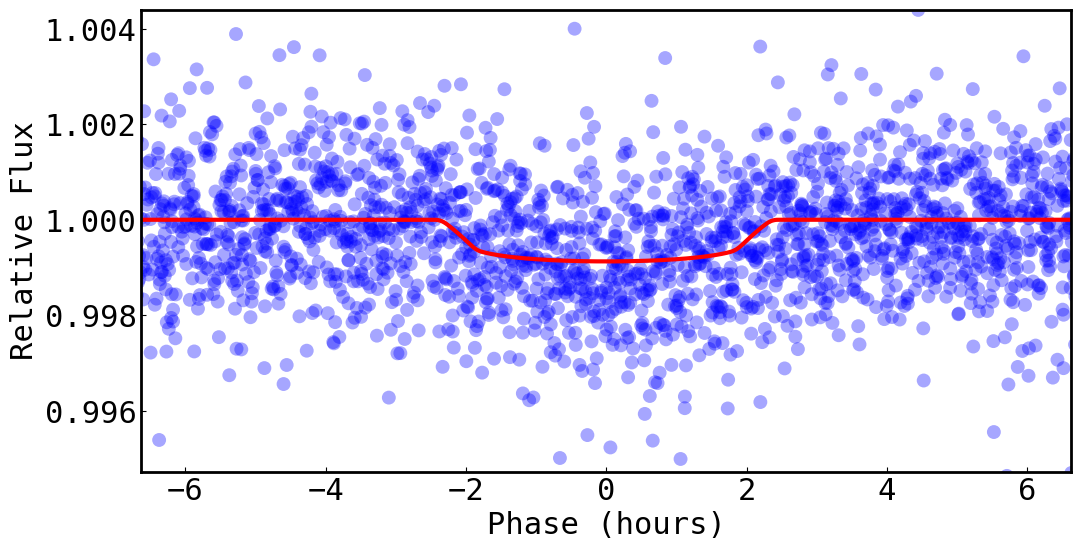

In [38]:
pl_plot = 1
transitp.plotTransit(phot, sol_fit, pl_to_plot=pl_plot)

## MCMC

- add tqdm to MCMC chain generation to give user an indication of progress
- add flag to remove verbose output
- add figure generation that plots a selection of models from MCMC to show scatter. 

In [55]:
import utils_python.transitmcmc as tmcmc
import matplotlib.pyplot as plt

In [48]:
nsteps1 = 10000 #total length of chain will be nwalkers*nsteps
nsteps2 = 50000#200000 #nstep1 is to check that MCMC is okay, nstep2 is the real work.
nsteps_inc = 50000#100000
burninf=0.5 #burn-in for evalulating convergence
niter_cor=5000
burnin_cor=1000
nthin=101
nloopmax=5
converge_crit=1.02 #Convergence criteria
buf_converge_crit=1.2 #Convergence criteria for buffer

In [49]:
# Bring up the data to have median around 1
# phot.flux += 1
if np.rint(np.median(phot.flux)) != 1:
    raise ValueError

# Generate input for mcmc
lnprob, x, beta = tmcmc.genmcmcInput(sol_fit, params_to_fit)
sol_a = sol_fit.to_array()
serr = sol_fit.err_to_array()

# Cut out of transit
phot_cut = tmcmc.cutOutOfTransit(sol_fit, phot)

params = [nsteps1, nsteps2, nsteps_inc, burninf, niter_cor, burnin_cor, nthin, nloopmax, converge_crit, buf_converge_crit]

In [52]:
chain, accept, burnin = tmcmc.demcmcRoutine(x, beta, phot_cut, sol_a, serr, params, lnprob)

runtest: [0.02378323 0.00842323 0.00030046 0.00010877]
Current Acceptance:  [0.01267829 0.77849117 0.53216374 0.56065089 0.02263083 0.02332362]
Current Acceptance:  [0.0523338  0.48847926 0.37957317 0.35097493 0.06557377 0.08721805]
Current Acceptance:  [0.19466248 0.19883041 0.22720478 0.21060842 0.25183016 0.26984127]
Current Acceptance:  [0.36111111 0.12643678 0.22720478 0.1761194  0.25183016 0.26984127]
Current Acceptance:  [0.43731343 0.12195122 0.22720478 0.18614719 0.25183016 0.26984127]
Current Acceptance:  [0.3940678  0.19139466 0.22720478 0.23502994 0.25183016 0.26984127]
Current Acceptance:  [0.30387597 0.25516224 0.22720478 0.23502994 0.25183016 0.26984127]
Current Acceptance:  [0.20909091 0.25516224 0.22720478 0.23502994 0.25183016 0.26984127]
Current Acceptance:  [0.17018072 0.25516224 0.22720478 0.23502994 0.25183016 0.26984127]
Current Acceptance:  [0.17937853 0.25516224 0.22720478 0.23502994 0.25183016 0.26984127]
Current Acceptance:  [0.21353383 0.25516224 0.22720478 

In [53]:
# print(output.stdout)

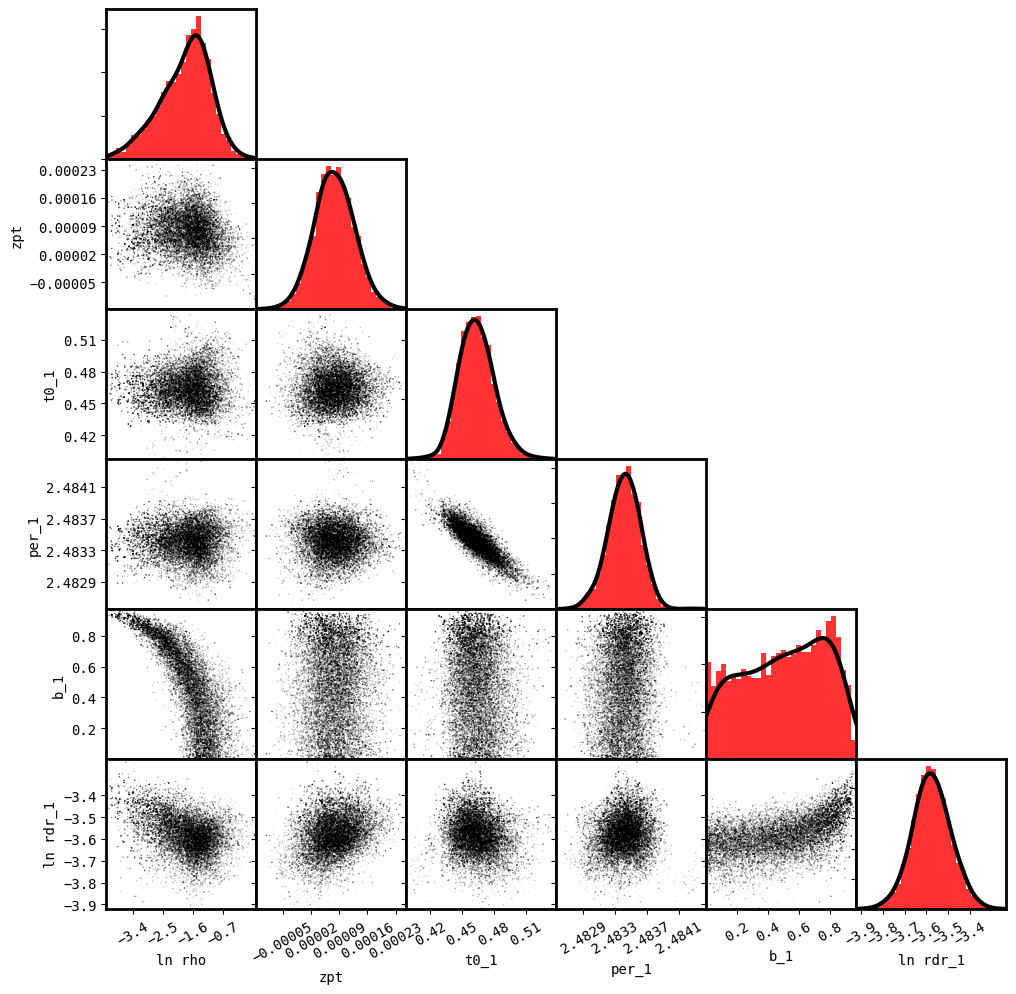

In [57]:
label = ["ln rho", "zpt", "t0_1", "per_1", "b_1", "ln rdr_1", "t0_2", "per_2", "b_2", "ln rdr_2", "t0_3", "per_3", "b_3", "ln rdr_3"]
color = ["red"]*14

plt.rcParams['font.size'] = 10
mcmc.triplot(chain, burnin, label, color, 30)

In [58]:
sol_mcmc = tmcmc.getParams(chain, burnin, sol, params_to_fit)
transitp.printParams(sol_mcmc)

ρ* (g/cm³):                     0.1779753 ± 0.1330599
c1:                                   0.0 ± 0.0
c2:                                   0.0 ± 0.0
q1:                             0.3545084 ± 0.0000000
q2:                             0.3205229 ± 0.0000000
Dilution:                             0.0 ± 0.0
Velocity Offset:                      0.0 ± 0.0
Photometric zero point:         7.723e-05 ± 4.916e-05
t0 (days):                      0.4630215 ± 0.0167168
Period (days):                  2.4834202 ± 0.0002029
Impact parameter:               0.5251900 ± 0.2683424
Rp/R*:                          0.0279594 ± 0.0024525
sqrt(e)cos(w):                        0.0 ± 0.0
sqrt(e)sin(w):                        0.0 ± 0.0
RV Amplitude (m/s):                   0.0 ± 0.0
Thermal eclipse depth (ppm):          0.0 ± 0.0
Ellipsoidal variations (ppm):         0.0 ± 0.0
Albedo amplitude (ppm):               0.0 ± 0.0


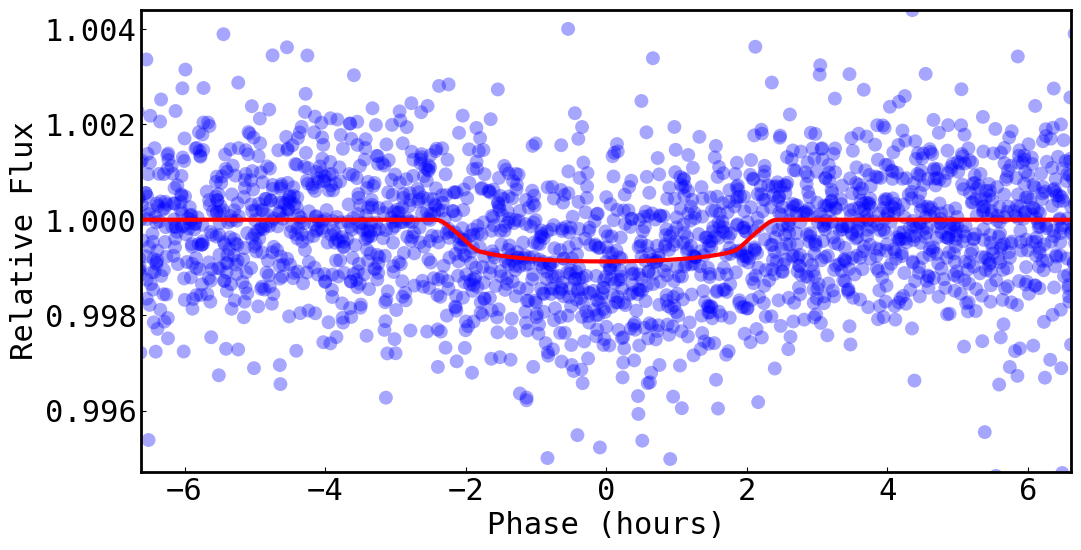

In [59]:
pl_plot = 1
transitp.plotTransit(phot, sol_mcmc, pl_to_plot=pl_plot)

In [94]:
from matplotlib import rcParams
from utils_python.transitmodel import transitModel

def plot_data(time, flux, itime, sol, x1 = 0, x2 = 0, y1 = 0, y2 = 0):

    period = sol.per
    t0     = sol.t0

    t_model = transitModel(sol, time, itime)

    phase = (time - t0) / period - np.floor( (time - t0) / period ) 

    phase[phase>0.5] = phase[phase>0.5] - 1.0

    phase = phase * period * 24

    p_sort = np.argsort(phase)

    rcParams.update({'font.size': 22}) # Adjust font
    plt.figure(figsize=(12,6)) # Adjust size of figure
    if type(flux) is not int:
        plt.scatter(phase, flux, c="blue", s=100.0, alpha=0.35, edgecolors="none") #scatter plot

    plt.plot(phase[p_sort], t_model[p_sort], color='red', lw=3)

    plt.xlabel('Phase (hours)') #x-label
    plt.ylabel('Relative Flux') #y-label
    

    if x1 == x2:
        x1 = np.min(phase)
        x2 = np.max(phase)
    
    if y1 == y2:
        y1 = np.median(flux) - 3.0 * np.std(flux)
        y2 = np.median(flux) + 3.0 * np.std(flux)

    plt.axis((x1, x2, y1, y2))

    plt.show()

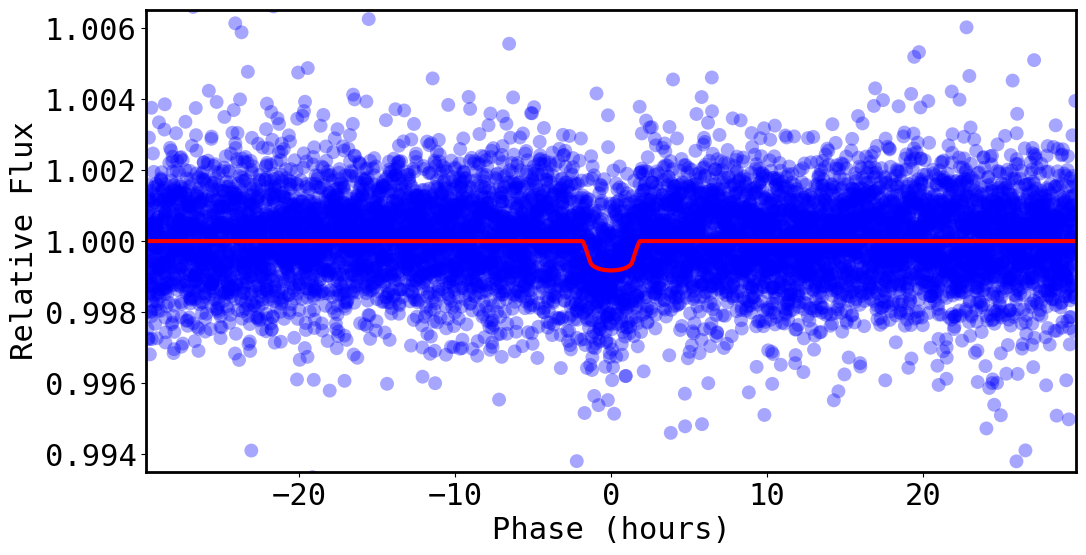

In [95]:
plot_data(phot.time, phot.flux, phot.itime, sol)

In [69]:
sol.per

[2.4831886856318546]